# Load Data & Preprocess
do some data exploration here and maybe based on that explain what we're going to do

In [1]:
from pathlib import Path
from os.path import abspath
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold

In [2]:
home_path = Path(abspath(''))
train_data_path = home_path.joinpath('data/train_2025.csv')
test_data_path = home_path.joinpath('data/test_2025.csv')
test_answers_path = home_path.joinpath('data/answer_key_2025.csv')

In [3]:
X_dataframe = pd.read_csv(train_data_path)
test_X_dataframe = pd.read_csv(test_data_path)
test_y_dataframe = pd.read_csv(test_answers_path)

In [4]:
X_dataframe.head()

,Gene 1,Gene 2,Gene 3,Gene 4,Gene 5,Gene 6,Gene 7,Gene 8,Gene 9,Gene 10,...,Gene 1993,Gene 1994,Gene 1995,Gene 1996,Gene 1997,Gene 1998,Gene 1999,Gene 2000,Outcome,Id
0,4.0,107.0,135.0,15752.0,459.0,189.0,222.0,2258.0,2992.0,77.0,...,156.0,18368.0,318.0,89.0,307.0,82.0,227.0,302.0,3,3328
1,4.0,96.0,130.0,13704.0,486.0,244.0,298.0,NaN,1874.0,50.0,...,82.0,21033.0,375.0,NaN,426.0,91.0,232.0,116.0,1,2085
2,5.0,139.0,71.0,13866.0,326.0,418.0,402.0,2833.0,1821.0,64.0,...,122.0,13853.0,244.0,114.0,273.0,87.0,219.0,NaN,3,2455
3,3.0,135.0,47.0,14945.0,432.0,239.0,224.0,3020.0,2958.0,69.0,...,50.0,16328.0,289.0,NaN,NaN,98.0,244.0,312.0,3,2457
4,2.0,69.0,48.0,8758.0,337.0,214.0,358.0,NaN,3388.0,80.0,...,119.0,10714.0,557.0,99.0,206.0,107.0,136.0,364.0,1,3641



Total missing values across features: 497869
Missing values per feature (showing non-zero counts):
Gene 1       250
Gene 2       237
Gene 3       266
Gene 4       255
Gene 5       249
            ... 
Gene 1996    239
Gene 1997    253
Gene 1998    259
Gene 1999    252
Gene 2000    236
Length: 2000, dtype: int64

Total infinite values: 0
Total negative values: 0

Class counts:
Outcome
3    1280
2     881
1     730
0     629
Name: count, dtype: int64

Class proportions:
Outcome
3    0.363636
2    0.250284
1    0.207386
0    0.178693
Name: count, dtype: float64

Number of highly correlated feature pairs (r > 0.95): 59
A few example pairs (feature1, feature2, correlation):
('Gene 4', 'Gene 1323', 0.9999999926269247)
('Gene 8', 'Gene 1822', 0.9999994950756063)
('Gene 32', 'Gene 888', 0.9999999662673033)
('Gene 39', 'Gene 84', 0.9999991915915484)
('Gene 39', 'Gene 848', 0.9999996451767204)

Maximum expression value in the data: 51663.0
Minimum expression value in the data: 0.0

Feature with

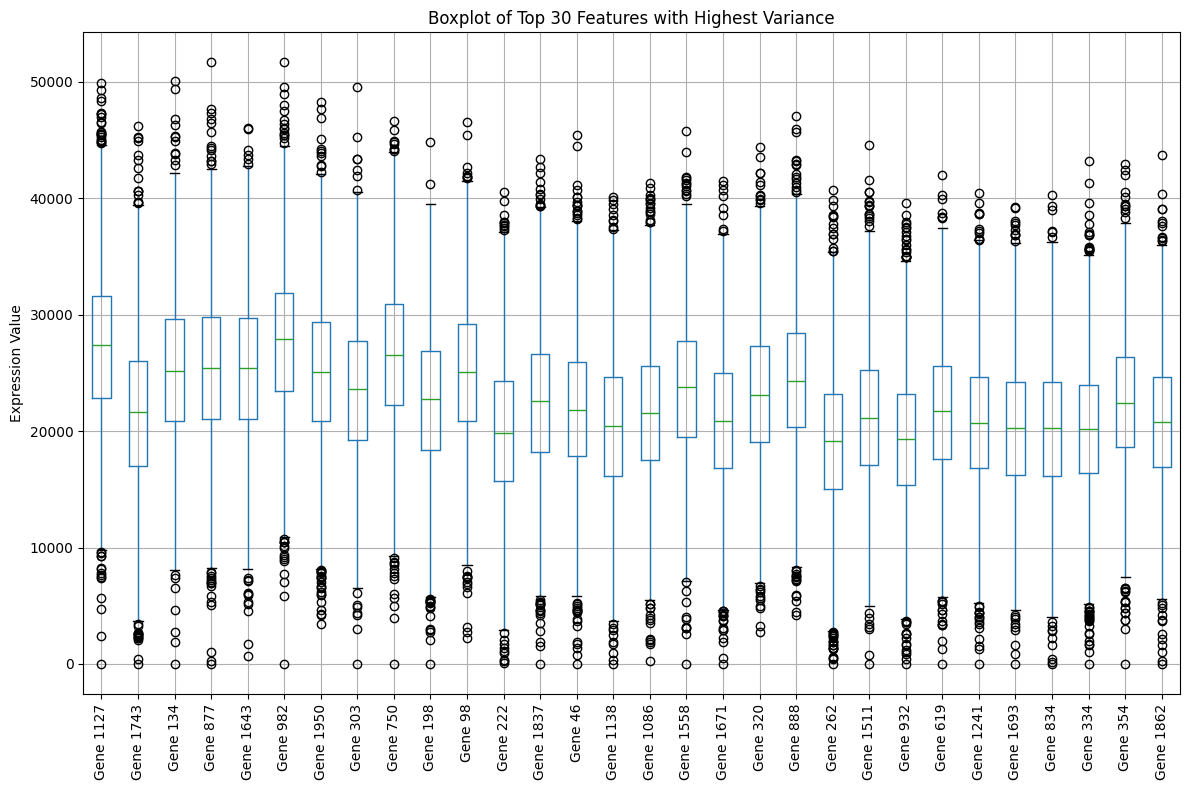

In [5]:
# --- Assume the following dataframes are already loaded:
# X_dataframe (training data with gene expression features and a label column, e.g. "label")
# test_X_dataframe and test_y_dataframe are loaded similarly

# Seperate features and target variable
target_name = 'Outcome'
labels = X_dataframe[target_name]
features = X_dataframe.drop([target_name, 'Id'], axis=1) # DROPPING ID HERE BUT MIGHT BE GOOD TO LEAVE IN

# 1. Count missing data
missing_counts = features.isna().sum()
total_missing = missing_counts.sum()
print("\nTotal missing values across features:", total_missing)
print("Missing values per feature (showing non-zero counts):")
print(missing_counts[missing_counts > 0])

# 2. Check for other strange values
# Here we check for infinite values and negative values.
num_infinite = np.isinf(features.values).sum()
num_negative = (features < 0).sum().sum()
print("\nTotal infinite values:", num_infinite)
print("Total negative values:", num_negative)
# (Depending on your data processing, gene expression data might be expected to be non-negative.)

# 3. Proportion of classes (if labels available)
if labels is not None:
    class_counts = labels.value_counts()
    print("\nClass counts:")
    print(class_counts)
    print("\nClass proportions:")
    print(class_counts / class_counts.sum())

# 4. Check for extremely high correlation between features.
# We define "extremely highly correlated" as absolute Pearson correlation > 0.95.
corr_matrix = features.corr().abs()
threshold = 0.95
high_corr_pairs = []
cols = corr_matrix.columns

# Count only unique pairs (i < j to avoid double counting)
for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        if corr_matrix.iloc[i, j] > threshold:
            high_corr_pairs.append((cols[i], cols[j], corr_matrix.iloc[i, j]))

print("\nNumber of highly correlated feature pairs (r > 0.95):", len(high_corr_pairs))
if len(high_corr_pairs) > 0:
    print("A few example pairs (feature1, feature2, correlation):")
    for pair in high_corr_pairs[:5]:
        print(pair)

# 5. Maximum and minimum values in the features
max_val = features.max().max()
min_val = features.min().min()
print("\nMaximum expression value in the data:", max_val)
print("Minimum expression value in the data:", min_val)

# 6. Feature with the highest variance.
variances = features.var()
top_feature = variances.idxmax()
print("\nFeature with the highest variance:", top_feature)
print("Highest variance value:", variances.max())

# Additionally, demonstrate scikit-learn's VarianceThreshold.
vt = VarianceThreshold(threshold=0)  # threshold 0 selects all non-constant features
vt.fit(features)
# vt.variances_ holds the variances for each feature (in the same order as features.columns)
print("\nFirst five variances using VarianceThreshold:", vt.variances_[:5])

# 7. Boxplot of the top 30 features with highest variance.
# Identify top 30 features ordered by variance
top30_features = variances.sort_values(ascending=False).head(30).index
plt.figure(figsize=(12, 8))
# Boxplot for each selected feature
features[top30_features].boxplot(rot=90)
plt.title("Boxplot of Top 30 Features with Highest Variance")
plt.ylabel("Expression Value")
plt.tight_layout()
plt.show()


# HOW TO IMPROVE DATA EXPLORE
- have all this in formation in the graphs

# Downsample data

In [6]:
from imblearn.under_sampling import RandomUnderSampler

# Assume X is your features and y is your labels
rus = RandomUnderSampler(random_state=42)
X_downSampled, y_downSampled = rus.fit_resample(features, labels)

# Checking:
class_counts = y_downSampled.value_counts()
print("\nClass counts:")
print(class_counts)


Class counts:
Outcome
0    629
1    629
2    629
3    629
Name: count, dtype: int64


# 9. Random forest
- exercises:
    - Write down in one or two paragraphs how a RF works, mentioning what the Gini impurity is and how it is used, and how bootstrapping per tree and random feature subsampling per split are used to automatically combat overfitting. ❌
    - Report the following:
        - The cross validation performances (AUC ROC OVR, F1 macro) of the Random Forest classifier. ✅
        - How much better or worse then regularised logistic regression the RF classifier performs ❌
        - The 5 features that had the highest feature importance (and the associated feature importances) in the final RF trained on all training data. ✅
        - A plot for each of these 5 features that shows the distribution of the feature split by class in the training data (see this). ✅


- no feature scaling applied
- look into which features are reported as important and maybe compare to other methods?

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, f1_score, make_scorer
from sklearn.model_selection import StratifiedKFold
import seaborn as sns

In [8]:
global_seed = 42

In [9]:
# splitting the data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_downSampled, y_downSampled, train_size=0.8, test_size=0.2, stratify=y_downSampled, random_state=global_seed)

In [10]:
# Initialise pipeline 

# Possible hyperparameters to play with:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

# Required by exercise
# n_estimators=250 
# n_jobs=-2 to use all but one CPU to speed up the fitting
rfc = RandomForestClassifier(
    n_estimators=20, # CHANGE FOR FINAL
    criterion='gini',
    n_jobs=-2,
    random_state=global_seed
)

pipe = Pipeline(steps=[
    ('impute', SimpleImputer()),
    ('random_forest', rfc)
])
pipe.fit(X_train, y_train)

# Test on validation set
# y_pred = pipe.predict(X_val)
# y_proba = pipe.predict_proba(X_val) 

# Which metrics to use
# See total list: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
scoring = ['roc_auc_ovr','f1_macro']

# Get scores using cross validation 
score = cross_validate(pipe, X_val, y_val, cv=5, scoring=scoring)
print(score)

{'fit_time': array([0.08431387, 0.08282328, 0.08248901, 0.11961889, 0.08415985]), 'score_time': array([0.06554914, 0.06332898, 0.06347585, 0.06127787, 0.06436896]), 'test_roc_auc_ovr': array([0.66043354, 0.71234143, 0.65681511, 0.61573549, 0.6312    ]), 'test_f1_macro': array([0.35559524, 0.48355025, 0.41412288, 0.34313241, 0.36815436])}


## Most important features
sources: 
- https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
- https://pandas.pydata.org/docs/reference/api/pandas.Series.sort_values.html

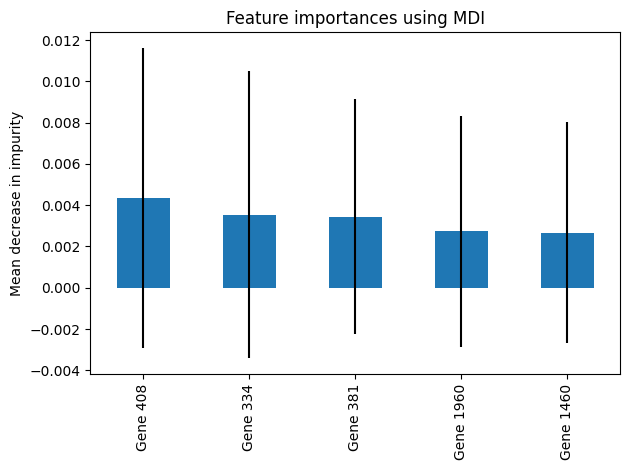

In [11]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
std = np.sort(std)[::-1][:5] # Keep 5 most important features
forest_importances = pd.Series(importances, index=features.columns)
forest_importances = forest_importances.sort_values(ascending=False)[:5] # Keep 5 most important features

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### How these top 5 features are distributed per class

Sources:
- https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn.displot
- https://seaborn.pydata.org/generated/seaborn.FacetGrid.html
- https://pandas.pydata.org/docs/user_guide/merging.html

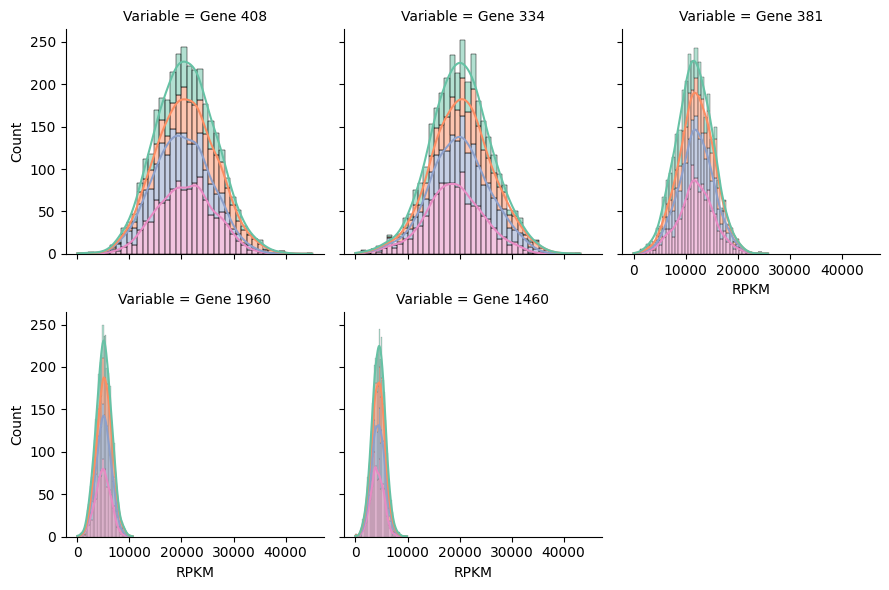

In [12]:
data = features[forest_importances.index] # Filter for most important features
data = pd.concat((data, labels), axis=1) # add labels as a column
data_long = data.melt(id_vars=['Outcome'] ,var_name='Variable', value_name='RPKM') # format data to long format, RPKM =Reads Per Kilobase Mapped

graph = sns.FacetGrid(data_long, col='Variable', col_wrap=3, )
graph.map_dataframe(sns.histplot, x ='RPKM', hue='Outcome', multiple='stack', kde=True, palette='Set2')
plt.show()

# 10 Neural network
Finally, I want you to train a simple feedforward dense/fully-connected neural network on this data. Use ReLU activation functions, and 3 hidden layers with 30, 20, and 10 neurons, and 4 output neurons for the classification (with a softmax activation). Do like we did before: define a function to make your neural net in Keras, make a scikit-learn object out of it, and train it with cross-validation. Don’t perform hyperparameter optimalisation for the neural network here. That could become very time-consuming. Scale the data, but rather than imputing nans just set them all to -1. 

In [13]:
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation, Flatten, Input

In [14]:
# Model / data parameters
num_classes = 4
input_shape = (28, 28, 1)

#function to build our model
def build_neural_net(input_shape=(2000,), hiddenLayerOne=30, hiddenLayerTwo=20, hiddenLayerThree=10, learnRate=0.01):
    # initialize a sequential model and add layer to flatten the input data
    model = Sequential()

    model.add(Input(input_shape))
    model.add(Dense(hiddenLayerOne, activation="relu"))
    model.add(Dropout(0.3))
              
    model.add(Dense(hiddenLayerTwo, activation="relu"))
    model.add(Dropout(0.3))

    model.add(Dense(hiddenLayerThree, activation="relu"))
    model.add(Dropout(0.3))
              
    # add a softmax layer on top
    model.add(Dense(4, activation="softmax"))
              
    # compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learnRate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"])
              
    # return compiled model
    return model

model = KerasClassifier(model=build_neural_net, verbose=0)

pipe = Pipeline([
    ('normilization', StandardScaler()), 
    ('model', model)
])

# Convert dataframe to numpy array
X_train_array = np.array(X_train)
y_train_array = np.array(y_train)
X_val_array = np.array(X_val)
y_val_array = np.array(y_val)

# Replace Nan values with -1
X_train_array = np.where(np.isnan(X_train_array), -1, X_train_array)
X_val_array = np.where(np.isnan(X_val_array), -1, X_val_array)

#### NOTE PART OF THE PIPELINE IS SCALING THIS SHOULD BE DONE WITH MEAN FROM THE TRAIN DATA NOT VAL DATA CHECK IF THIS IS THE CASE
pipe.fit(X_train_array, y_train_array)
pipe.score(X_val_array, y_val_array)

0.38293650793650796

# Ideas:
- Plot prediction against Y to get a quick high level  view of the performance
- Consider Halving gridsearch or do randomized search to decrease computation time:
    - https://scikit-learn.org/stable/auto_examples/model_selection/plot_successive_halving_heatmap.html#sphx-glr-auto-examples-model-selection-plot-successive-halving-heatmap-py
    - https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py
- Plot computation time for experiment
- Quantile transform to get rid of outliers
    - Effect of transforms to get a better result. Maybe brute force it?
- plot_output(scaler=scaler) # to get a easy visualisation of what the scaler is doing